In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import tqdm # progress bar
import copy
import random

#### Make the sum of all the datasets


In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/TR/data_tr'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/TR/data_tr/INCART 2-lead Arrhythmia Database.csv
/content/drive/MyDrive/TR/data_tr/MIT-BIH Arrhythmia Database.csv
/content/drive/MyDrive/TR/data_tr/MIT-BIH Supraventricular Arrhythmia Database.csv
/content/drive/MyDrive/TR/data_tr/Sudden Cardiac Death Holter Database.csv


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TR/data_tr/MIT-BIH Arrhythmia Database.csv')
df2 = pd.read_csv('/content/drive/MyDrive/TR/data_tr/INCART 2-lead Arrhythmia Database.csv')
df3 = pd.read_csv('/content/drive/MyDrive/TR/data_tr/MIT-BIH Supraventricular Arrhythmia Database.csv')
df4 = pd.read_csv('/content/drive/MyDrive/TR/data_tr/Sudden Cardiac Death Holter Database.csv')

df.drop('record', axis='columns', inplace=True)
df2.drop('record', axis='columns', inplace=True)
df3.drop('record', axis='columns', inplace=True)
df4.drop('record', axis='columns', inplace=True)

print(df.shape)
df.head()

<ipython-input-24-ff9ef0a63f04>:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv('/content/drive/MyDrive/TR/data_tr/Sudden Cardiac Death Holter Database.csv')


(100689, 33)


,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,N,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,18,...,0.025930,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436
1,N,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,4,...,-0.042009,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986
2,N,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,3,...,0.009528,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368
3,N,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,4,...,-0.020536,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555
4,N,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,4,...,0.016053,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155


#### Carga los datasets en general

del 2 3 4 solo se cogen los casos positivos y del primero de los normales solo hasta igualar los casos con problemas
sustiuye los valores y y crea las las labels

In [ ]:
df = df[df.notnull().all(axis=1)]
df2 = df2[df2.notnull().all(axis=1)]
df3 = df3[df3.notnull().all(axis=1)]
df4 = df4[df4.notnull().all(axis=1)]

### Solo para las variaciones de la seleción de características

In [ ]:
time_interval = ['type', '0_qrs_interval', '0_pq_interval', '0_qt_interval', '0_st_interval', '1_qrs_interval', '1_pq_interval', '1_qt_interval', '1_st_interval']
peak_interval = ['type', '0_pPeak', '0_tPeak', '0_rPeak', '0_sPeak', '0_qPeak', '1_pPeak', '1_tPeak', '1_rPeak', '1_sPeak', '1_qPeak']
morph_interval = ['type', '0_pre-RR', '0_post-RR', '0_qrs_morph0', '0_qrs_morph1', '0_qrs_morph2', '0_qrs_morph3', '0_qrs_morph4', '1_pre-RR', '1_post-RR', '1_qrs_morph1', '1_qrs_morph1', '1_qrs_morph2', '1_qrs_morph3', '1_qrs_morph4']

In [ ]:
df = df[morph_interval]
df2 = df2[morph_interval]
df3 = df3[morph_interval]
df4 = df4[morph_interval]

In [ ]:
y_label = df[['type']]
y_label.replace(['VEB', 'SVEB', 'F', 'Q'], 'arrhythmia', inplace=True)
y_label.replace(['N'], 'normal', inplace=True)

y_label2 = df2[['type']]
y_label2.replace(['VEB', 'SVEB', 'F', 'Q'], 'arrhythmia', inplace=True)
y_label2.replace(['N'], 'normal', inplace=True)

y_label3 = df3[['type']]
y_label3.replace(['VEB', 'SVEB', 'F', 'Q'], 'arrhythmia', inplace=True)
y_label3.replace(['N'], 'normal', inplace=True)

y_label4 = df4[['type']]
y_label4.replace(['VEB', 'SVEB', 'F', 'Q'], 'arrhythmia', inplace=True)
y_label4.replace(['N'], 'normal', inplace=True)

y_label2.value_counts()


<ipython-input-26-3ee3dde74e90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_label.replace(['VEB', 'SVEB', 'F', 'Q'], 'arrhythmia', inplace=True)
<ipython-input-26-3ee3dde74e90>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_label.replace(['N'], 'normal', inplace=True)
<ipython-input-26-3ee3dde74e90>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_label2.replace(['VEB', 'SVEB', 'F', 'Q'], 'arrhythmia', inplace=True)
<ipyth

,count
type,
normal,153546
arrhythmia,22183


In [ ]:
num_arrythmia = len(y_label[y_label['type']=='arrhythmia']) + len(y_label2[y_label2['type']=='arrhythmia']) + len(y_label3[y_label3['type']=='arrhythmia']) + len(y_label4[y_label4['type']=='arrhythmia'])
num_arrythmia

68111

### Make the split into the features and the labels

In [ ]:
num_sel_rand = random.randint(0, num_arrythmia - (num_arrythmia//4))

arr1 = df.loc[y_label['type']=='arrhythmia']
nor1 = df.loc[y_label['type']=='normal'][num_sel_rand:num_sel_rand + (num_arrythmia//4)]

arr2 = df2.loc[y_label2['type']=='arrhythmia']
nor2 = df2.loc[y_label2['type']=='normal'][num_sel_rand:num_sel_rand + (num_arrythmia//4)]

arr3 = df3.loc[y_label3['type']=='arrhythmia']
nor3 = df3.loc[y_label3['type']=='normal'][num_sel_rand:num_sel_rand + (num_arrythmia//4)]

arr4 = df4.loc[y_label4['type']=='arrhythmia']
nor4 = df4.loc[y_label4['type']=='normal'][num_sel_rand:num_sel_rand + (num_arrythmia//4)]


In [ ]:

arr1 = df.loc[y_label['type']=='arrhythmia']
nor1 = df.loc[y_label['type']=='normal'][:(num_arrythmia//4)]

arr2 = df2.loc[y_label2['type']=='arrhythmia']
nor2 = df2.loc[y_label2['type']=='normal'][:num_arrythmia//4]

arr3 = df3.loc[y_label3['type']=='arrhythmia']
nor3 = df3.loc[y_label3['type']=='normal'][:num_arrythmia//4]

arr4 = df4.loc[y_label4['type']=='arrhythmia']
nor4 = df4.loc[y_label4['type']=='normal'][:num_arrythmia//4]


In [ ]:
x_data = pd.concat([arr1.iloc[:, 1:], nor1.iloc[:, 1:], arr2.iloc[:, 1:], nor1.iloc[:, 1:], arr3.iloc[:, 1:], nor3.iloc[:, 1:], arr4.iloc[:, 1:], nor4.iloc[:, 1:]])
y_label = pd.concat( [nor1[['type']], nor2[['type']], nor3[['type']], nor4[['type']], y_label.loc[y_label['type'] == 'arrhythmia'], y_label2.loc[y_label2['type'] == 'arrhythmia'], y_label3.loc[y_label3['type'] == 'arrhythmia'], y_label4.loc[y_label4['type'] == 'arrhythmia']])


In [ ]:
y_label.value_counts()

,count
type,
arrhythmia,68111
N,68108


In [ ]:
x_data

,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,0_qt_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
360,24.0,357.0,0.049120,1.399257,1.113826,-0.361193,-1.952061,40.0,16.0,69.0,...,-0.031889,7.0,18.0,39.0,14.0,-0.031889,-0.121138,-0.206488,-0.339001,-0.379213
420,194.0,426.0,-0.063861,-0.311834,1.283616,-0.320058,-0.098463,23.0,5.0,31.0,...,0.002576,3.0,4.0,10.0,3.0,0.002576,0.002576,0.000681,0.000681,-0.000659
644,333.0,414.0,0.035873,-0.351159,1.295646,-0.401133,0.002740,23.0,5.0,35.0,...,0.023875,16.0,3.0,27.0,8.0,0.023875,0.025495,0.029146,0.022849,-0.007689
899,386.0,343.0,-0.189489,1.359877,-0.224210,-0.378801,-0.224210,5.0,2.0,20.0,...,0.143144,26.0,8.0,133.0,99.0,0.143144,0.189707,0.157048,0.050664,-0.201991
1537,237.0,459.0,-0.005417,-0.303479,1.355476,-0.323771,-0.105282,22.0,8.0,34.0,...,-0.005574,33.0,5.0,44.0,6.0,-0.005574,-0.005132,0.011613,0.025870,0.018329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18971,216.0,212.0,-0.037566,0.100432,0.310824,-0.323157,-0.099188,43.0,10.0,139.0,...,-0.443129,4.0,19.0,37.0,14.0,-0.443129,-0.443129,-0.434847,-0.402937,-0.355927
18972,212.0,214.0,0.028514,0.109866,0.334616,-0.331646,-0.076427,42.0,29.0,163.0,...,-0.451102,4.0,20.0,38.0,14.0,-0.451102,-0.451102,-0.442078,-0.408821,-0.359268
18973,214.0,212.0,-0.063016,0.088938,0.335454,-0.335120,-0.063683,34.0,3.0,120.0,...,-0.464661,5.0,19.0,37.0,13.0,-0.464661,-0.443900,-0.402271,-0.348552,-0.290595
18974,212.0,214.0,-0.005815,0.093412,0.282148,-0.309554,-0.073484,42.0,12.0,146.0,...,-0.436719,4.0,19.0,38.0,15.0,-0.436719,-0.436719,-0.420270,-0.382463,-0.331903


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_label, test_size=0.2, random_state=33)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train)

y_train_scaled = encoder.transform(y_train)
y_test_scaled = encoder.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


#### Transform to tensors

In [ ]:
X_train = torch.tensor(x_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(x_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32).reshape(-1, 1)

In [ ]:
len(x_train_scaled[0])

32

### Define the binary classificator

In [ ]:
class Model(nn.Module):
    def __init__(self, init_char):
        super().__init__()
        self.layer1 = nn.Linear(init_char, 24)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(24, 24)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(24, 10)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
loss_record = []


def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 40   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
    batches_per_epoch = len(X_train) // batch_size

    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
      model.train()
      for i in range(batches_per_epoch):
        start = i * batch_size
        Xbatch = X_train[start:start+batch_size]
        ybatch = y_train[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()


      # evaluate trained model with test set
      loss_record.append(loss.item())
      model.eval()
      with torch.no_grad():
        y_pred = model(X_val)
      accuracy = (y_pred.round() == y_val).float().mean()
      print("Epoch: " + str(epoch) + " --> Accuracy {:.2f}".format(accuracy * 100))


    # restore model and return best accuracy
    #model.load_state_dict(best_weights)
    #return best_acc

In [ ]:
model = Model(32)

model_train(model, X_train, y_train, X_test, y_test)

Epoch: 0 --> Accuracy 88.90
Epoch: 1 --> Accuracy 89.71
Epoch: 2 --> Accuracy 90.32
Epoch: 3 --> Accuracy 90.74
Epoch: 4 --> Accuracy 91.01
Epoch: 5 --> Accuracy 91.38
Epoch: 6 --> Accuracy 91.72
Epoch: 7 --> Accuracy 92.15
Epoch: 8 --> Accuracy 92.27
Epoch: 9 --> Accuracy 92.67
Epoch: 10 --> Accuracy 93.25
Epoch: 11 --> Accuracy 93.69
Epoch: 12 --> Accuracy 94.31
Epoch: 13 --> Accuracy 94.70
Epoch: 14 --> Accuracy 95.08
Epoch: 15 --> Accuracy 95.41
Epoch: 16 --> Accuracy 95.70
Epoch: 17 --> Accuracy 95.87
Epoch: 18 --> Accuracy 96.07
Epoch: 19 --> Accuracy 96.18
Epoch: 20 --> Accuracy 96.28
Epoch: 21 --> Accuracy 96.30
Epoch: 22 --> Accuracy 96.30
Epoch: 23 --> Accuracy 96.37
Epoch: 24 --> Accuracy 96.38
Epoch: 25 --> Accuracy 96.36
Epoch: 26 --> Accuracy 96.26
Epoch: 27 --> Accuracy 96.10
Epoch: 28 --> Accuracy 96.18
Epoch: 29 --> Accuracy 96.20


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/TR/models/HBV_lr_0,001.pt')

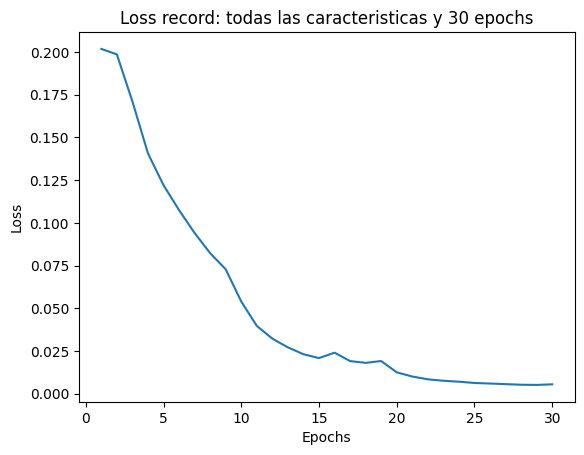

In [ ]:
plt.plot(np.arange(1, 31), loss_record)  # Plot the chart
plt.xlabel("Epochs")  # add X-axis label
plt.ylabel("Loss")  # add Y-axis label
plt.title("Loss record: todas las caracteristicas y 30 epochs")  # add title
plt.show()  # display

In [ ]:
with torch.no_grad():
    y_val = model(X_test)


correct = 0

for i in range(len(X_test)):
    #print(f' Predicted: ', round(y_val[i].item()),  ' Real: ', y_test[i].item()  )


    if round(y_val[i].item()) == y_test[i].item():
        correct += 1
    #    print(correct)

accuracy = correct / len(X_test) * 100
print(f'The accuracy is {accuracy} %')




The accuracy is 96.71854353252091 %
